**Лекция 8**

# Гребневая регрессия #
**и другие методы борьбы с плохо обусловленными матрицами**

# Плохо обусловленные системы #
**и как с ними быть**

# Сингулярное разложение матриц #
**и его применение в задачах восстановления регрессии**

> Данный ноутбук практически полностью основан на курсе лекций К.В. Воронцова [&laquo;Машинное обучение&raquo;](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2%29), а именно на параграфе, посвящённом линейной регрессии.
Основным отличием от оригинала является код на Питоне, позволяющий ученику &laquo;поиграть&raquo; с методами и тем самым глубже разобраться в материале.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Суть-проблемы" data-toc-modified-id="Суть-проблемы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Суть проблемы</a></span></li><li><span><a href="#Обусловленность" data-toc-modified-id="Обусловленность-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обусловленность</a></span><ul class="toc-item"><li><span><a href="#Число-обусловленности" data-toc-modified-id="Число-обусловленности-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Число обусловленности</a></span></li><li><span><a href="#Геометрическая-интерпретация" data-toc-modified-id="Геометрическая-интерпретация-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Геометрическая интерпретация</a></span></li></ul></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Линейная регрессия</a></span><ul class="toc-item"><li><span><a href="#Генерация-данных" data-toc-modified-id="Генерация-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Генерация данных</a></span></li><li><span><a href="#Полиномиальная-регрессия" data-toc-modified-id="Полиномиальная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Полиномиальная регрессия</a></span></li></ul></li><li><span><a href="#Сингулярное-разложение" data-toc-modified-id="Сингулярное-разложение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сингулярное разложение</a></span></li><li><span><a href="#Проблема-мультиколлинеарности" data-toc-modified-id="Проблема-мультиколлинеарности-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проблема мультиколлинеарности</a></span></li><li><span><a href="#Метод-главных-компонент" data-toc-modified-id="Метод-главных-компонент-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Метод главных компонент</a></span></li><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Гребневая регрессия</a></span><ul class="toc-item"><li><span><a href="#Выбор-константы-регуляризации" data-toc-modified-id="Выбор-константы-регуляризации-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Выбор константы регуляризации</a></span></li></ul></li><li><span><a href="#Лассо-Тибширани" data-toc-modified-id="Лассо-Тибширани-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Лассо Тибширани</a></span></li><li><span><a href="#Сравнение-лассо-и-гребневой-регрессии" data-toc-modified-id="Сравнение-лассо-и-гребневой-регрессии-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Сравнение лассо и гребневой регрессии</a></span></li><li><span><a href="#Источники" data-toc-modified-id="Источники-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Источники</a></span></li></ul></div>

In [2]:
# Imports
import sys
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [3]:
# Styles
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['lines.markersize'] = 4
cm = plt.cm.tab10  # Colormap

import seaborn
seaborn.set_style('whitegrid')

---

---

## Суть проблемы ##

Пусть дана исходная система линейных уравнений
$$ A \mathbf{x} = \mathbf{b}, $$
где $A$ &mdash; квадратная невырожденная матрица порядка $n$.

В этом случае система имеет единственное решение $\mathbf{x} = A^{-1} \mathbf{b}$.

Решение системы линейных уравнений можно интерпретировать, как разложение вектора $\mathbf{b}$ по вектор-столбцам матрицы $A$.

Рассмотрим матрицу
$$
  A = 
  \begin{pmatrix}
    1.0 & 1.0 \\
    1.0 & 1.2
  \end{pmatrix}.
$$

Её столбцы, практически, коллинеарны.
Из общих соображений понятно, что выбирать эти столбцы в качестве базисных &mdash; плохая идея.
Разложение любого вектора по таким столбцам может привести к ошибкам.

In [199]:
A = np.array([[1.0, 1.0],
              [1.0, 1.2]])

origin = [[0,0], [0,0]] # origin point

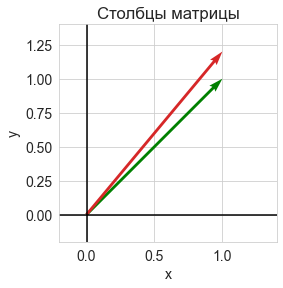

In [200]:
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
plt.subplots_adjust(wspace=0.4)

# Plotting y1
ax1.quiver(*origin, A[:,0], A[:,1], color=['g', cm(3)],
           width=0.013, angles='xy', scale_units='xy', scale=1)
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14)
ax1.set_xlim([-0.2, 1.4])
ax1.set_ylim([-0.2, 1.4])
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.set_title("Столбцы матрицы")
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
# ax1.text(1, 0.1, "$\mathbf{x}$", fontsize=16)
# ax1.text(0.8, 0.6, "$\mathbf{Ax}$", fontsize=16)

plt.show()

Посмотрим, как появляются эти ошибки.

Пусть вектор $\mathbf{b}$ известен не точно, а с некоторой погрешностью.
Посмотрим, какова будет погрешность решения системы &mdash; вектора $\mathbf{x}$.

> Здесь и далее на рисунках вектор правых частей изображается на *правом* рисунке (&laquo;После преобразования&raquo;), а вектор решения &mdash; на *левом* (&laquo;До преобразования&raquo;).

In [297]:
# Creating the vectors for a circle and storing them in x
# Solution
x = np.zeros((400, 1))
y0 = np.array([2**-0.5, 2**-0.5]).reshape(-1, 1)
A_inv = LA.inv(A)
x0 = A_inv @ y0

# Noise
n = 100
np.random.seed(42)
r = 0.07*np.random.randn(n)
phi = np.pi*np.random.rand(n)
y1_1 = y0[0] + r*np.cos(phi)
y1_2 = y0[1] + r*np.sin(phi)
Y = np.vstack((y1_1, y1_2))
X = A_inv @ Y

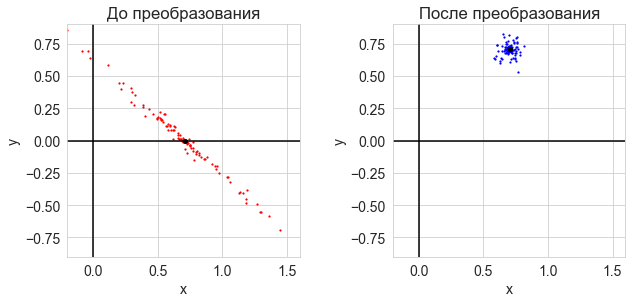

In [299]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,15))

plt.subplots_adjust(wspace=0.4)
xlims = [-0.2, 1.6]
ylims = [-0.9, 0.9]

# Plotting X
ax1.plot(X[0,:], X[1,:], 'o', ms=1.2, color='r')
ax1.plot(x0[0], x0[1], 'o', color='k')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.set_title("До преобразования")
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
# ax1.text(0.3, -1.3, "$\mathbf{X}$", color='b')

# Plotting Y
ax2.plot(Y[0, :], Y[1, :], 'o', ms=1.2, color='b')
ax2.plot(y0[0], y0[1], 'o', color='k')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax2.set_aspect('equal')
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_title("После преобразования")
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')
# ax2.text(1.0, -1.7, "$\mathbf{CX}$", color='b')

# plt.savefig('1.png', dpi=300, bbox_inches='tight')
plt.show()

Мы видим, что небольшое возмущение вектора правой части $\mathbf{b}$ привела к гораздо большим возмущениям вектора решений $\mathbf{x}$.
В таком случае говорят, что система уравнений является *плохо обусловленной*.
Разберёмся подробнее, что это значит.

In [303]:
# x_sol = np.array([1.0, 0.0]).T
dx = X - x0
dy = Y - y0

k1 = np.array(list(map(LA.norm, dy.T))) / LA.norm(y0)
k2 = np.array(list(map(LA.norm, dx.T))) / LA.norm(x0)

print(round(max(k2/k1), 2))

14.88


---

## Обусловленность ##

### Число обусловленности ###

Рассмотрим возмущённую систему
$$ A \tilde{\mathbf{x}} = \mathbf{b} + \delta\mathbf{b}. $$

Введём вектор возмущения решения $\delta \mathbf{x} = \tilde{\mathbf{x}} - \mathbf{x}$.

Выразим $\mathbf{x}$ и $\delta\mathbf{x}$ через обратную матрицу $A^{-1}$:
$$ \delta \mathbf{x} = A^{-1}(\mathbf{b} + \delta\mathbf{b}) - A^{-1}\mathbf{b} = A^{-1}\delta\mathbf{b}. $$

Перейдём к оценке нормы возмущения:
$$ \|\delta \mathbf{x}\| = \|A^{-1} \delta \mathbf{b}\| \le \|A^{-1}\| \cdot \|\delta \mathbf{b}\|. $$

Учитывая, что $\|\mathbf{b}\| \le \|A\| \cdot \|\mathbf{x}\|$, усилим неравенство, умножим правую часть на $\|A\| \cdot \dfrac{\|\mathbf{x}\|}{\|\mathbf{b}\|}$:
$$ \|\delta \mathbf{x}\| \le \|A^{-1}\| \|A\| \|\mathbf{x}\| \frac{\|\delta \mathbf{b}\|}{\|\mathbf{b}\|}. $$

Наконец, разделим на $\|\mathbf{x}\|$:
$$ \frac{\|\delta \mathbf{x}\|}{\|\mathbf{x}\|} \le \|A^{-1}\| \|A\| \frac{\|\delta \mathbf{b}\|}{\|\mathbf{b}\|}. $$

Мы получили связь между относительной погрешностью решения и относительной погрешностью правой части системы уравнений.

**Определение.**
Величина $c(A) = \|A^{-1}\| \|A\|$ называется *числом обусловленности* матрицы $A$ в рассматриваемой норме. Она показывает, во сколько раз может возрасти относительная погрешность решения по сравнению с относительной погрешностью правой части.

Число обусловленности определяется не только матрицей, но и выбором нормы.
Рассмотрим один из наиболее употребительных вариантов &mdash; *спектральное число обусловленоности*.
Согласно формуле для спектральной нормы матрицы
$$ c(A) = \dfrac{\sigma_1}{\sigma_n}, $$
где $\sigma_1$ и $\sigma_n$ &mdash; максимальной и минимальной сингулярные числа матрицы $A$.

In [304]:
U, sgm, Vt = LA.svd(A)
print('sigma = ', np.round(sgm, 2))
print('c(A) = ', round(sgm[0]/sgm[1], 2))

sigma =  [2.1 0.1]
c(A) =  22.15


### Геометрическая интерпретация ###

Дадим геометрическую интерпретацию числа обусловленности.

In [312]:
# Creating the vectors for a circle and storing them in x
r = 0.1
y0 = np.array([2**-0.5, 2**-0.5]).T
phi = np.linspace(0, 2*np.pi, 100)
y1_1 = y0[0] + r*np.cos(phi)
y1_2 = y0[1] + r*np.sin(phi)
Yc = np.vstack((y1_1, y1_2))

# 
A_inv = LA.inv(A)
x0 = A_inv @ y0
Xc = A_inv @ Yc

# 
x1_1 = x0[0] + r*np.cos(phi)
x1_2 = x0[1] + r*np.sin(phi)
X_r = np.vstack((x1_1, x1_2))

In [308]:
# x_tilde = Xc[:,38]
# y_tilde = A @ x_tilde

# dx = x_tilde - x0
# dy = y_tilde - y0

# k1 = LA.norm(dy) / LA.norm(y0)
# k2 = LA.norm(dx) / LA.norm(x0)

# print(k2 / k1)

14.88426858430233


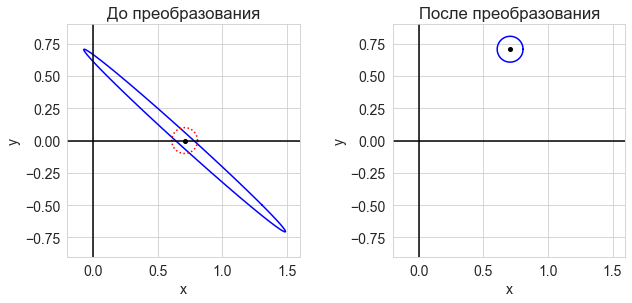

In [313]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,15))

plt.subplots_adjust(wspace=0.4)
xlims = [-0.2, 1.6]
ylims = [-0.9, 0.9]

# Plotting X
ax1.plot(x0[0], x0[1], 'o', color='k')
ax1.plot(Xc[0,:], Xc[1,:], color='b')
ax1.plot(X_r[0,:], X_r[1,:], ':', color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.set_title("До преобразования")
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
# ax1.text(0.3, -1.3, "$\mathbf{X}$", color='b')

# Plotting Y
ax2.plot(y0[0], y0[1], 'o', color='k')
ax2.plot(Yc[0, :], Yc[1, :], color='b')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax2.set_aspect('equal')
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_title("После преобразования")
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')
# ax2.text(1.0, -1.7, "$\mathbf{CX}$", color='b')

# plt.savefig('1.png', dpi=300, bbox_inches='tight')
plt.show()

Видно, что ...

---

## Линейная регрессия ##

### Генерация данных ###

In [316]:
def pol(a, x):
    return np.sum([a[i]*x**i for i in range(len(a))], axis=0)

def sin(a, x):
    return np.sin(a*x)

def xsin(a, x):
    return x*np.sin(a*x)

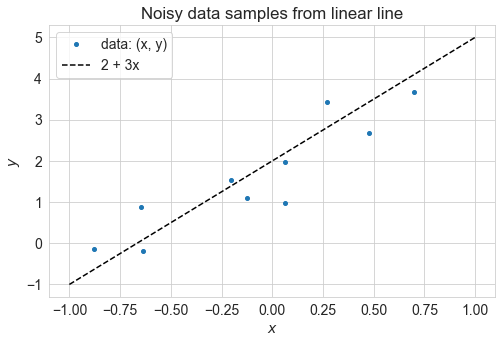

In [317]:
# Define the data
np.random.seed(123)
Ns = 10 # Number of samples
# x_lim = np.array([0, 1])
x_lim = np.array([-1, 1])

# Underlying functional relation
fun = pol
a = [2, 3]
label = f'{a[0]} + {a[1]}x'
# fun = sin
# a = 5
# label = f'sin({a}x)'

# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(Ns)  # Noise

# Features and output
x = np.random.uniform(x_lim[0], x_lim[1], Ns)  # Independent variable x
# x = np.linspace(x_lim[0], x_lim[1], Ns)  # Independent variable x
y = fun(a, x) + err  # Dependent variable

# Show data
X = np.linspace(x_lim[0], x_lim[1], 100)
plt.figure(figsize=(8, 5))
plt.title('Noisy data samples from linear line')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

### Полиномиальная регрессия ###

In [407]:
# The number of fetures
Nf = 7
# Stack X with ones to be fitted by vectorized methods such as OLS and gradient descent
F = np.ones_like(x)
for i in range(1, Nf):
    F = np.vstack((F, x**i))
F = F.T
# print(F)
    
# Fit parameters with OLS
Alpha = np.linalg.inv(F.T @ F) @ F.T @ y
print(Alpha)

# Function representing fitted line
f = lambda x: sum([Alpha[i]*x**i for i in range(Nf)])

[   1.15220094    4.77921315   29.39798055  -36.1272129  -134.75066819
   67.44024456  154.82651278]


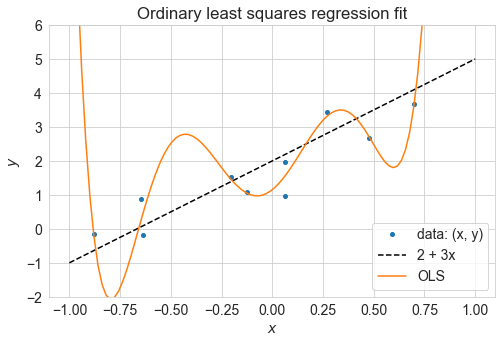

In [408]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ordinary least squares regression fit')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Сингулярное разложение ##

Рассмотрим матрицу $F$ размерностью $l \times n$. Для определённости будем считать, строк не меньше чем столбцов и столбцы линейно независимы, т.е. $n \le l$ и $\mathrm{Rg}F = n$.

Произвольную матрицу $F$ размерностью $l \times n$ ранга $n$ можно представить в виде сингулярного разложения (singular value decomposition, SVD)
$$ F = VDU^\top. $$

**Свойства сингулярного разложения:**
1. матрица $D$ размером $n \times n$ диагональна, $ D = \mathrm{diag}\left( \sqrt{\lambda_1}, \ldots, \sqrt{\lambda_n}\right) $, где $\lambda_1, \ldots, \lambda_n$ &mdash; общие ненулевые собственные значения матриц $F^\top F$ и $FF^\top$;
2. матрица $V = (v_1, \ldots, v_n)$ размером $l \times n$ ортогональна, $V^\top V = I_n$, столбцы $v_j$ являются собственными векторами матрицы $FF^\top$, соответствующими $\lambda_1, \ldots, \lambda_n$;
3. матрица $U = (u_1, \ldots, u_n)$ размером $n \times n$ ортогональна, $U^\top U = I_n$, столбцы $u_j$ являются собственными векторами матрицы $F^\top F$, соответствующими $\lambda_1, \ldots, \lambda_n$.

Имея сингулярное разложение, легко записать
 - псевдообратную матрицу:
$$ F^{+} = (UDV^\top VDU^\top)^{-1}UDV^\top = UD^{-1}V^\top = \sum_{j=1}^n \frac{1}{\sqrt{\lambda_j} }u_j v_j^\top;  \label{eq:psevdo}\tag{1} $$
 
 - вектор МНК-решения:
$$ \alpha^* = F^{+} y  = UD^{-1}V^\top y = \sum_{j=1}^n \frac{1}{\sqrt{\lambda_j}}u_j (v_j^\top y);  \label{eq:alpha-res}\tag{2} $$
 
 - вектор $F\alpha^*$ &mdash; МНК-аппроксимацию целевого вектора $y$:
$$ F\alpha^* = P_F y = (VDU^\top)UD^{-1}V^\top y = VV^\top y = \sum_{j=1}^n v_j (v_j^\top y);  \label{eq:F-alpha-res}\tag{3} $$
 
 - норму вектора коэффициентов:
$$ \Vert \alpha^* \Vert^2 = y^\top VD^{-1}U^\top UD^{-1}V^\top y = y^\top VD^{-2}V^\top y = \sum_{j=1}^n \frac{1}{\lambda_j} (v_j^\top y)^2.  \label{eq:alpha-res-norm}\tag{4} $$

---

## Проблема мультиколлинеарности ##

Если ковариационная матрица $\Sigma = F^\top F$ имеет неполный ранг, то её обращение невозможно.
Тогда приходится отбрасывать линейно зависимые признаки или применять описанные ниже методы &mdash; регуляризацию или метод главных компонент.
На практике чаще встречается проблема *мультиколлинеарности* &mdash; когда матрица $\Sigma$ имеет полный ранг, но близка к некоторой матрице неполного ранга.
Тогда говорят, что $\Sigma$ &mdash; матрица неполного псевдоранга или что она плохо обусловлена.
Геометрически это означает, что объекты выборки сосредоточены вблизи линейного подпространства меньшей размерности $m < n$.
Признаком мультиколлинеарности является наличие у матрицы $\Sigma$ собственных значений, близких к нулю.

**Определение.** *Число обусловленности* матрицы $\Sigma$ есть
$$ \mu(\Sigma) = \left\Vert \Sigma \right\Vert \Vert \Sigma^{-1} \Vert = \frac{\underset{u:\, \Vert u\Vert = 1}{\max} \Vert \Sigma u \Vert}{\underset{u:\, \Vert u\Vert = 1}{\min} \Vert \Sigma u \Vert} = \frac{\lambda_{\max}}{\lambda_{\min}}, $$

где $\lambda_{\max}$ и $\lambda_{\min}$ &mdash; максимальное и минимальное собственные значения матрицы $\Sigma$.

Матрица считается плохо обусловленной, если $\mu(\Sigma) \gtrsim 10^2 \div 10^4$.
Обращение такой матрицы численно неустойчиво.
При умножении обратной матрицы на вектор, $z = \Sigma^{-1}u$, относительная погрешность усиливается в $\mu(\Sigma)$ раз:
$$ \frac{\Vert \delta z \Vert}{\Vert z \Vert} \le \mu(\Sigma) \frac{\Vert \delta u \Vert}{\Vert u \Vert}.$$

Именно это и происходит с МНК-решением в случае плохой обусловленности.
В формуле ([4](#mjx-eqn-eq:alpha-res-norm)) близкие к нулю собственные значения оказываются в знаменателе, в результате увеличивается разброс коэффициентов $\alpha^*$, появляются большие по абсолютной величине положительные и отрицательные коэффициенты.
МНК-решение становится неустойчивым &mdash; малые погрешности измерения признаков или ответов
у обучающих объектов могут существенно повлиять на вектор решения $\alpha^*$, а погрешности измерения признаков у тестового объекта $x$ &mdash; на значения функции регрессии $g(x, \alpha^*)$.
Мультиколлинеарность влечёт не только неустойчивость и переобучение, но и неинтерпретируемость коэффициентов, так как по абсолютной величине коэффициента $\alpha_j$ становится невозможно судить о степени важности признака $f_j$.
Проблема мультиколленеарности никак не проявляется на обучающих данных: вектор $F\alpha^*$ не зависит от собственных значений $\lambda$ (см. формулу ([3](#mjx-eqn-eq:F-alpha-res))).

---

## Метод главных компонент ##

Как он сработает для полиномиальной регрессии?

In [409]:
V, d, Ut = np.linalg.svd(F, full_matrices=False)
# print(V)
print(f'd = {d}')
# print(Ut.T)

mu = (d[0]/d[-1])**2
print(f'число обусловленности mu = {mu}')

d = [3.35347844 1.83764121 0.84631111 0.34807406 0.13585743 0.02843847
 0.00497056]
число обусловленности mu = 455176.775821429


In [426]:
Npc = 2
# Fit parameters with SVD
Alpha_svd = sum([1/d[i] * Ut[i] * (V.T[i] @ y) for i in range(Npc)])
print(Alpha_svd)

# Function representing fitted line
f_svd = lambda x: sum([Alpha_svd[i]*x**i for i in range(Nf)])

[ 1.90334903  1.60150458 -0.08352231  0.80660848 -0.21549925  0.48473182
 -0.21190629]


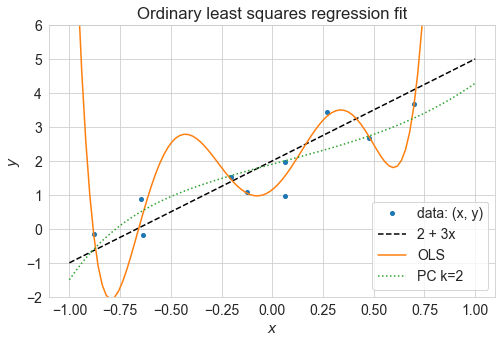

In [427]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ordinary least squares regression fit')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.plot(X, f_svd(X), ':', label=f'PC k={Npc}')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Гребневая регрессия ##

Для решения проблемы мультиколлинеарности добавим к функционалу $Q$ регуляризатор, штрафующий большие значения нормы вектора весов $\Vert \alpha \Vert$:

$$ Q_\tau(\alpha) = \Vert F\alpha - y \Vert^2 + \tau \Vert \alpha \Vert^2, $$

где $\tau$ &mdash; неотрицательный параметр.
В случае мультиколлинеарности имеется бесконечно много векторов $\alpha$, доставляющих функционалу $Q$ значения, близкие к минимальному.
Штрафное слагаемое выполняет роль регуляризатора, благодаря которому среди них выбирается решение с минимальной нормой.
Приравнивая нулю производную $Q_\tau (\alpha)$ по параметру $\alpha$, находим:

$$ \alpha_\tau^\ast = (F^\top F + \tau I_n)^{-1} F^\top y. $$

Таким образом, перед обращением матрицы к ней добавляется &laquo;гребень&raquo; &mdash; диагональная матрица $\tau I_n$.
Отсюда и название метода &mdash; гребневая регрессия (ridge regression).
При этом все её собственные значения увеличиваются на $\tau$ , а собственные векторы не изменяются.
В результате матрица становится хорошо обусловленной, оставаясь в то же время &laquo;похожей&raquo; на исходную.

Выразим регуляризованное МНК-решение через сингулярное разложение:
$$ \alpha_\tau^* = (UD^2 U^\top + \tau I_n)^{-1} UDV^\top y = U(D^2 + \tau I_n)^{-1} DV^\top y = \sum_{j=1}^n \frac{\sqrt{\lambda_j}}{\lambda_j + \tau} u_j (v_j^\top y).  \label{eq:alpha-tau-res}\tag{5} $$

> В формуле \eqref{eq:alpha-tau-res} используется так называемое &laquo;проталкивающее равенство&raquo; ([push-through identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity)): $A(I + BA)^{-1} = (I + AB)^{-1}A$.

Теперь найдём регуляризованную МНК-аппроксимацию целевого вектора $y$:
$$ F\alpha_\tau^\ast = VDU^\top \alpha_\tau^* = V \mathrm{diag}\left( \frac{\lambda_j}{\lambda_j + \tau} \right) V^\top y = \sum_{j=1}^n \frac{\lambda_j}{\lambda_j + \tau} v_j (v_j^\top y).  \label{eq:F-alpha-tau-res}\tag{6} $$

Как и прежде в ([3](#mjx-eqn-eq:F-alpha-res)), МНК-аппроксимация представляется в виде разложения целевого вектора $y$ по базису собственных векторов матрицы $FF^\top$.
Только теперь проекции на собственные векторы сокращаются, умножаясь на $\frac{\lambda_j}{\lambda_j + \tau} \in (0, 1)$. В сравнении с ([4](#mjx-eqn-eq:alpha-res-norm)) уменьшается и норма вектора коэффициентов:

$$ \Vert \alpha_\tau^{\ast} \Vert^2 = \Vert U(D^2 + \tau I_n)^{-1} DV^\top y \Vert^2  = \sum_{j=1}^n \frac{\lambda_j}{(\lambda_j + \tau)^2} (v_j^\top y)^2 < \sum_{j=1}^n \frac{1}{\lambda_j} (v_j^\top y)^2 = \Vert \alpha^{\ast} \Vert^2. \label{eq:alpha-tau-es-norm}\tag{7} $$


### Выбор константы регуляризации ###

Из формулы \eqref{eq:alpha-tau-res} видно, что при $\tau \to 0$ регуляризованное решение стремится к МНК-решению: $\alpha_\tau^\ast \to \alpha^\ast$.
При $\tau \to \infty$ чрезмерная регуляризации приводит к вырожденному решению: $\alpha^\ast_\tau \to 0$.
Оба крайних случая нежелательны, поэтому оптимальным является некоторое промежуточное значение $\tau^\ast$.
Для его нахождения можно применять, например, скользящий контроль.

Известна практическая рекомендация брать $\tau$ в отрезке [0.1, 0.4], если столбцы матрицы $F$ заранее
стандартизованы (центрированы и нормированы).
Ещё одна эвристика &mdash; выбрать $\tau$ так, чтобы число обусловленности приняло заданное не слишком большое значение: $M_0 = \mu(F^\top F + \tau I_n) = \frac{\lambda_\max + \tau}{\lambda_\min + \tau}$, откуда следует рекомендация $\tau^\ast \approx \lambda_\max/M_0$.

In [347]:
# Fit parameters with ridge regression
M_0 = 1e2    # desired condition number
tau = max(d)**2 / M_0
print(f'd = {d}')
print(f'tau = {tau}')
Alpha_r = sum([d[i]/(d[i]**2+tau) * Ut[i] * (V.T[i] @ y) for i in range(Nf)])
print(f'Alpha_r = {Alpha_r}')

# Function representing fitted line
ridge = lambda x: sum([Alpha_r[i]*x**i for i in range(Nf)])

d = [3.35347844 1.83764121 0.84631111 0.34807406 0.13585743 0.02843847
 0.00497056]
tau = 0.11245817628216104
Alpha_r = [1.68081274 2.18712059 0.46765421 0.33858729 0.05017935 0.1247591
 0.03022377]


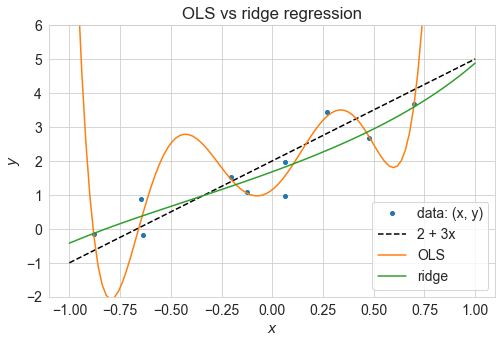

In [348]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('OLS vs ridge regression')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.plot(X, ridge(X), '-', label='ridge')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Лассо Тибширани ##

Ещё один метод регуляризации внешне похож на гребневую регрессию, но приводит к качественно иному поведению вектора коэффициентов.
Вместо добавления штрафного слагаемого к функционалу качества вводится ограничение-неравенство, запрещающее слишком большие абсолютные значения коэффициентов:

$$
\left\{
\begin{align}
    & Q(\alpha) = \Vert F\alpha - y \Vert^2 \to \min_\alpha \\
    & \sum\limits_{j=1}^n |\alpha_j| \le \chi
\end{align}
\right.,
\label{eq:lasso}\tag{8}
$$
где $\chi$ &mdash; параметр регуляризации.
При больших значениях $\chi$ ограничение \eqref{eq:lasso} становится строгим неравенством, и решение совпадает с МНК-решением.
Чем меньше $\chi$, тем больше коэффициентов $\alpha_j$ обнуляются.
Происходит отбор (селекция) признаков, поэтому параметр $\chi$ называют ещё *селективностью*.
Образно говоря, параметр $\chi$ зажимает вектор коэффициентов, лишая его избыточных степеней свободы.
Отсюда и название метода &mdash; *лассо* (LASSO, least absolute shrinkage and selection operator). 

In [349]:
import scipy as sp
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

In [350]:
def Q_obj(a):
    '''Q - objective function'''
    return np.linalg.norm((F @ a - y))**2

def constr(a):
    '''Constraint'''
    return np.sum(abs(a))

def solve_lasso(Q_obj, constr, chi):
    '''solve LASSO optimization task'''
    nonlinear_constraint = NonlinearConstraint(constr, 0., chi)
    N_ms = 10   # multistart
    res = []
    for i in range(N_ms):
    # Alpha_0 = np.zeros(Nf)    # initial approximation
        Alpha_0 = 10*np.random.rand(Nf) - 5
        res.append(minimize(Q_obj, Alpha_0, method='SLSQP', constraints=nonlinear_constraint))
    argmin = np.argmin([item.fun for item in res])
    return res[argmin]

In [429]:
# solve LASSO optimization task
chi = 4    # the max constraint for the decision vector
res = solve_lasso(Q_obj, constr, chi)
Alpha_l = res.x
lasso = lambda x: sum([Alpha_l[i]*x**i for i in range(Nf)])

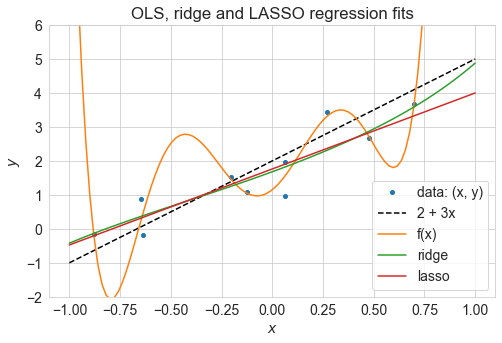

In [430]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('OLS, ridge and LASSO regression fits')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='f(x)')
plt.plot(X, ridge(X), '-', label='ridge')
plt.plot(X, lasso(X), '-', label='lasso')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

In [431]:
print(f'OLS:   a = {Alpha}  \n norm(a) = {constr(Alpha)},   Q = {Q_obj(Alpha_svd)}\n')
print(f'ridge: a = {Alpha_r}\n norm(a) = {constr(Alpha_r)}, Q = {Q_obj(Alpha_r)}\n')
print(f'LASSO: a = {Alpha_l}\n norm(a) = {constr(Alpha_l)}, Q = {Q_obj(Alpha_l)}\n')

OLS:   a = [   1.15220094    4.77921315   29.39798055  -36.1272129  -134.75066819
   67.44024456  154.82651278]  
 norm(a) = 428.4740330707647,   Q = 3.7148682048744677

ridge: a = [1.68081274 2.18712059 0.46765421 0.33858729 0.05017935 0.1247591
 0.03022377]
 norm(a) = 4.879337051881616, Q = 2.8531524369506758

LASSO: a = [ 1.76307716e+00  2.23692302e+00  7.75641626e-08 -1.28608056e-07
  1.92746983e-07  2.36620221e-07 -4.83297073e-09]
 norm(a) = 4.000000812515537, Q = 2.9828095754489943



---

## Сравнение лассо и гребневой регрессии ##

Оба метода успешно решают проблему мультиколлинеарности.
Гребневая регрессия использует все признаки, стараясь &laquo;выжать максимум&raquo; из имеющейся информации. Лассо производит отбор признаков, что предпочтительнее, если среди признаков есть шумовые или измерения признаков связаны с ощутимыми затратами.

Ниже приводится сравнение гребневой регресии и лассо.
Ослабление регуляризации (рост параметров $\sigma = 1/\tau$ и $\chi$) ведёт к уменьшению ошибки на обучении и увеличению нормы вектора коэффициентов.
При этом ошибка на контроле в какой-то момент проходит через минимум, и далее только возрастает &mdash; это и есть переобучение (проверить самостоятельно).

In [107]:
eps = 1e-2
Sigma = np.arange(eps, 1e3*eps, eps)
AA = np.empty((len(Sigma), len(d)))
for i, sigma in enumerate(Sigma):
    AA[i] = sum([d[i]/(d[i]**2+1/sigma) * Ut[i] * (V.T[i] @ y) for i in range(Nf)])

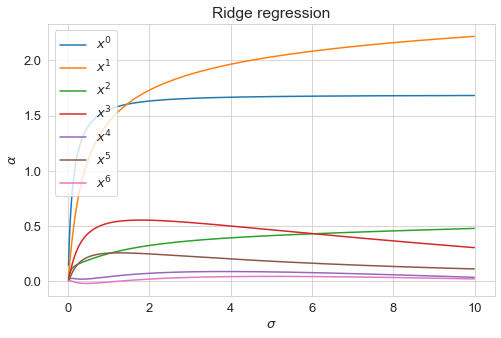

In [108]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ridge regression')

for i, aa in enumerate(AA.T):
    plt.plot(Sigma, aa, '-', label=f'$x^{i}$')
plt.xlabel('$\sigma$')
plt.ylabel(r'$\alpha$')
# plt.ylim((1, 6))
plt.legend(loc=2)
plt.show()

In [89]:
Chi = np.arange(1, 11, 1)
BB = np.empty((len(Chi), len(d)))

for i, chi in enumerate(Chi):
    res = solve_lasso(Q_obj, constr, chi)
    BB[i] = res.x
# print(res) 

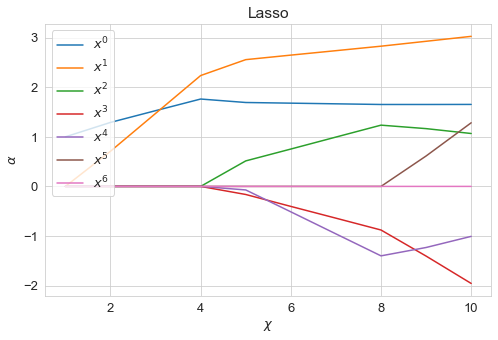

In [92]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Lasso')

for i, bb in enumerate(BB.T):
    plt.plot(Chi, bb, '-', label=f'$x^{i}$')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\alpha$')
# plt.ylim((1, 6))
plt.legend(loc=2)
plt.show()

---

## Источники ##

1. *Беклемишев Д.В.* Дополнительные главы линейной алгебры. &mdash; М.: Наука, 1983. &mdash; 336 с.
1. *Воронцов К.В.* [Математические методы обучения по прецедентам (теория обучения машин)](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf). &mdash; 141 c.
1. *Strang G.* Linear algebra and learning from data. &mdash; Wellesley-Cambridge Press, 2019. &mdash; 432 p.

In [111]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scipy: {}'.format(sp.__version__))

Python: 3.7.6
numpy: 1.18.1
matplotlib: 3.1.3
seaborn: 0.10.0
scipy: 1.4.1
